In [2]:
# all imports
import os
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import Any, Dict
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

2025-06-30 20:53:52.622855: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 20:53:52.632963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751288032.643293 1757852 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751288032.646439 1757852 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751288032.655600 1757852 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# set all the seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
tf.compat.v1.set_random_seed(42)

In [4]:
# check access to GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable dynamic memory allocation to avoid using all the GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs found: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print("Error during GPU configuration:", e)
else:
    print("No GPU detected. TensorFlow will use the CPU.")

GPUs found: ['/physical_device:GPU:0', '/physical_device:GPU:1']


In [5]:
# initialize parameters
# dataset specific
data_folder = '/home/soundarya/emodrink/other-datasets/WESAD/pickled-data'
fs = 700
modality_keys = ['ECG', 'EMG', 'EDA']
pid_num_list = np.arange(1, 18)
pid_list = [f'S{x}' for x in pid_num_list if x not in [1,12]]
ds_info = {
            'ds_name': 'wesad',
            'class_size': 4,
            'win_size': 1000,
            'mod_name': modality_keys,
            'mod_dim': [1,1,1],
            'labels' : ['Baseline','Stress','Amusement','Meditation'],
            'num_device' : 3,
            'sensor_per_device': [1,1,1]
        }
# model specific
mode = 'fine'
batch_size = 8
epoch_ssl = 100
epoch_cls = 50
filters = 64
masking = 'spatial'
code_size = 96 # output dimension of each encoder
proj_size = 32 # output dimension of the aggregrator / projector
coverage = 0.9
lr_ssl = 1e-4
lr_cls = 1e-3
loss_type = 'vicreg'
verbosity = 0
temp = 0.2
sim_coeff = 10.0
std_coeff = 10.0
cov_coeff = 100.0
log_dir = 'logs/'
os.makedirs(log_dir, exist_ok=True)

In [6]:
# dataset functions
def one_hot_encoder(in_array, num_unique_labels=-1):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(in_array)
    # binary encode
    if num_unique_labels == -1:
        onehot_encoder = OneHotEncoder(sparse_output=False) #sparse=False -- modified !!
    else:
        assert np.size(np.unique(in_array)) <= num_unique_labels, 'Too many labels!'
        onehot_encoder = OneHotEncoder(sparse_output=False, categories=[np.arange(num_unique_labels)])
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    cls_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return cls_onehot_encoded

def read_participant_data(pid, desired_classes = [1, 2, 3, 4]):
    """
    Load and preprocess WESAD participant data.
    Returns a dict of filtered sensor signals and re-labeled condition labels.
    """
    data_path = os.path.join(data_folder, f'{pid}.pkl')
    with open(data_path, 'rb') as f:
        data = pickle.load(f, encoding="latin1")
    signals = data['signal']['chest']  # dict: ECG, EMG, RESP, etc.
    labels = data['label']             # array: 1=baseline, 2=stress, 3=amusement, 4=meditation
    mask = np.isin(labels, desired_classes)
    filtered_signals = {sensor: sensor_data[mask]
                        for sensor, sensor_data in signals.items()}
    filtered_labels = labels[mask] - 1  # Shift labels to start from 0
    return filtered_signals, filtered_labels

def create_windows(data_dict, labels, feature_keys, window_size=1000, stride=1000):
    """
    Slice multivariate signals into overlapping windows and assign window labels.
    """
    X, y = [], []
    signal_length = len(labels)
    for idx in range(window_size, signal_length+1, stride):
        end = idx
        start = end - window_size
        # Stack selected features: result shape (window_size, num_features)
        window = np.concatenate([data_dict[feat][start:end]
                                 for feat in feature_keys], axis=1)
        # All label in window
        label_window = labels[start:end]
        # if all labels are not identical, skip
        unique_labels = np.unique(label_window)
        if np.size(unique_labels) != 1:
            continue
        X.append(window)
        y.append(unique_labels[0])
        # y.append(np.bincount(label_window).argmax())
    X = np.array(X); y = np.array(y)
    assert X.shape[0] == y.shape[0]
    return X, y

def prepare_split_datasets(pid_list, feature_keys, num_unique_labels=4, window_size=1000, stride=1000,
                           test_frac=0.2, valid_frac=0.2):
    """
    Prepare training and test sets for standard cross-validation.
    Args:
        pid_list (list): List of all participant IDs (e.g., ['S2', 'S3', ...])
        feature_keys (list): List of sensor names to include (e.g., ['ECG', 'EDA'])
        window_size (int): Number of time steps in each window
        stride (int): Stride for moving window
        split_ratio_frac (float): Fraction of Train Data / All Data
    Returns:
        X_train, y_train, X_test, y_test: Arrays ready for training/evaluation
    """
    X_data, y_data = [], []
    for pid in pid_list:
        signal_dict, labels = read_participant_data(pid)
        X_pid, y_pid = create_windows(signal_dict, labels, feature_keys, window_size, stride)
        X_data.append(X_pid)
        y_data.append(y_pid)
    X_data = np.concatenate(X_data, axis=0)
    y_data = np.concatenate(y_data, axis=0)
    # shuffle the data
    X_data, y_data = shuffle(X_data, y_data, random_state=42)
    valid_start = int(y_data.shape[0]*(1-test_frac-valid_frac))
    test_start = int(y_data.shape[0]*(1-test_frac))
    X_train, y_train = X_data[:valid_start], y_data[:valid_start]
    X_valid, y_valid = X_data[valid_start:test_start], y_data[valid_start:test_start]
    X_test, y_test = X_data[test_start:], y_data[test_start:]
    y_train = one_hot_encoder(y_train, num_unique_labels=num_unique_labels)
    y_valid = one_hot_encoder(y_valid, num_unique_labels=num_unique_labels)
    y_test = one_hot_encoder(y_test, num_unique_labels=num_unique_labels)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [7]:
class DotProduct(tf.keras.layers.Layer):
    def call(self, x, y):
        x = tf.nn.l2_normalize(x, axis=-1)
        y = tf.nn.l2_normalize(y, axis=-1)
        return tf.linalg.matmul(x, y, transpose_b=True)

class CMContrastiveModel(tf.keras.Model):
    def __init__(self, embedding_model, projection_model, coverage, masking, masking_threshold=0.9, **kwargs):
        super().__init__()
        self.encoder = embedding_model
        self.projector = projection_model
        self.coverage_rate = coverage
        # self._similarity_layer = DotProduct()
        self.masking_strategy = masking
        self.mask_threshold = masking_threshold
    
    @property
    def metrics(self):
        return []

    def get_random_indices(self, data_shape):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        if self.masking_strategy == 'random':
            rand = tf.random.uniform(shape=data_shape)
            mask_a = tf.where((rand < self.mask_threshold), 1.0, 0.0)
            rand = tf.random.uniform(shape=data_shape)
            mask_b = tf.where((rand < self.mask_threshold), 1.0, 0.0)
        elif self.masking_strategy == 'spatial':
            indices = tf.random.uniform(shape=(data_shape[0], data_shape[1]))
            indices = tf.where((indices < self.mask_threshold), 1.0, 0.0)
            mask_a = tf.expand_dims(indices, axis=-1)
            mask_a = tf.repeat(mask_a, repeats=data_shape[-1], axis=-1)
            indices = tf.random.uniform(shape=(data_shape[0], data_shape[1]))
            indices = tf.where((indices < self.mask_threshold), 1.0, 0.0)
            mask_b = tf.expand_dims(indices, axis=-1)
            mask_b = tf.repeat(mask_b, repeats=data_shape[-1], axis=-1)
        elif self.masking_strategy == 'temporal':
            indices = tf.random.uniform(shape=(data_shape[0], data_shape[2]))
            indices = tf.where((indices < self.mask_threshold), 1.0, 0.0)
            mask_a = tf.expand_dims(indices, axis=1)
            mask_a = tf.repeat(mask_a, repeats=data_shape[-1], axis=-1)
            indices = tf.random.uniform(shape=(data_shape[0], data_shape[1]))
            indices = tf.where((indices < self.mask_threshold), 1.0, 0.0)
            mask_b = tf.expand_dims(indices, axis=-1)
            mask_b = tf.repeat(mask_b, repeats=data_shape[-1], axis=-1)
        return mask_a, mask_b

    def train_step(self, data):
        with tf.GradientTape() as tape:
            modality_embeddings = self.encoder(data, training=False)
            modality_embeddings = tf.stack(modality_embeddings) # dimensions [mod, batch, code-size]
            # dim_size = len(modality_embeddings)
            modality_embeddings = tf.transpose(modality_embeddings, (1, 0, 2))  # Batch x Mod x code_size
            ind_a, ind_b = self.get_random_indices(modality_embeddings.shape) # ind_a and ind_b are masks, hence they're multiplied below
            comb_emb_a = modality_embeddings * ind_a
            comb_emb_b = modality_embeddings * ind_b
            rep_a, rep_b = self.projector(comb_emb_a), self.projector(comb_emb_b) # no training=False here becuase projector does not have any dropout / batchnorm which behave differently for training vs. inference
            loss = self.compiled_loss(rep_a, rep_b)
            # loss = self.compute_loss(y=rep_a, y_pred=rep_b) # modified compiled_loss !!
            loss += sum(self.losses)
            # loss += sum(self.projector.losses)
        trainable_vars = self.encoder.trainable_variables + self.projector.trainable_variables
        gradients = tape.gradient(loss, trainable_vars, )
        self.optimizer.apply_gradients(
            zip(gradients, trainable_vars))
        # updated !!
        # return {m.name: m.result() for m in self.metrics}
        return {"loss": loss}

In [8]:
# define the SSL models
# encoder - temporal convolutional network
def TCN(input_shape, filters, modality_name, code_size, l2_rate):
    initializer = tf.keras.initializers.RandomNormal(seed=0)
    input_x = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv1D(filters=int(code_size / 4), # number of output channels
                               kernel_size=24, # size of the convolution 1d filter
                               activation="linear", # no non-linearity after convolution
                               padding="same", # output will have same dimension as input
                               # strides=1,
                               kernel_regularizer=tf.keras.regularizers.l2(l2_rate), # add L2 penalty to kernel weights during training
                               kernel_initializer=initializer)(input_x) # weights initialization for kernel weights
    x = tf.keras.layers.LayerNormalization()(x) # performs normalization with two learned parameters -- mean, std per channel
    x = tf.keras.layers.PReLU(shared_axes=[1])(x) # parametric relu -- one learned parameters alpha
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(filters=int(code_size / 2),
                               kernel_size=16, # different kernel sizes are used for multi-scale representation, inner layers have smaller kernel size for fine-grained feature identification
                               activation="linear",
                               padding="same",
                               # strides=2,
                               kernel_regularizer=tf.keras.regularizers.l2(l2_rate),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU(shared_axes=[1])(x) # axis 1 is time-steps -- so alpha is shared amongst all time-steps in each channel
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(filters=code_size,
                               kernel_size=8,
                               activation="linear",
                               padding="same",
                               # strides=2,
                               kernel_regularizer=tf.keras.regularizers.l2(l2_rate),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU(shared_axes=[1])(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    output = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last', name='global_max_pooling1d')(x)
    return tf.keras.Model(input_x, output, name=modality_name)

def get_modality_encoder(input_shape, modality_name, filters, code_size, l2_rate):
    return TCN(input_shape, filters, modality_name, code_size, l2_rate)

def get_encoder(win_size, modality_name, modality_dim, code_size, modality_filters=24, l2_rate=1e-4):
    # modality specific encoders
    mod_encoder = []
    mod_input = []
    i = 0
    for m in modality_name:
        input_shape = (win_size, modality_dim[i])
        encoder = get_modality_encoder(input_shape,
                                       modality_name=m,
                                       filters=modality_filters,
                                       code_size=code_size,
                                       l2_rate=l2_rate)
        if i == 0:
            print(encoder.summary())
        mod_input.append(tf.keras.layers.Input(shape=input_shape))
        x_a = encoder(mod_input[-1])
        mod_encoder.append(x_a)
        i += 1
    embedding_model = tf.keras.Model(mod_input, mod_encoder) # includes encoders of all modalities
    print(embedding_model.summary())
    return embedding_model

def get_projector(code_size, proj_size, mod_no):
    input_shape = (mod_no, code_size) # [3, 96]
    embeddings = tf.keras.layers.Input(input_shape)
    proj = tf.keras.layers.Flatten()(embeddings)
    proj = tf.keras.layers.Dense(64, activation="relu")(proj)
    proj = tf.keras.layers.Dense(proj_size, activation="relu")(proj)
    proj = tf.keras.layers.Dense(proj_size)(proj)
    proj = tf.keras.layers.LayerNormalization()(proj)
    projection_model = tf.keras.Model(embeddings, proj, name="projection_head")
    print(projection_model.summary())
    return projection_model

def cm_model(ds_info, code_size, proj_size, modality_filters=32, l2_rate=1e-4, coverage=0.5, masking='random'):
    mod_coverage = len(ds_info['mod_name']) # number of modalities
    embedding_model = get_encoder(ds_info['win_size'], ds_info['mod_name'], ds_info['mod_dim'],
                                  code_size, modality_filters=modality_filters, l2_rate=l2_rate)
    projection_model = get_projector(code_size, proj_size, mod_coverage)
    return CMContrastiveModel(embedding_model, projection_model, mod_coverage, masking, masking_threshold=coverage)

In [9]:
#define custom loss
class CustomLoss:
    def __init__(
            self,
            temperature=0.5,
            tau=0.01,
            beta=2,
            sim_coeff=25,
            std_coeff=25,
            cov_coeff=1,
            std_const=1e-4,
            lambd=3.9e-3,
            scale_loss=1 / 32,
            reduction=tf.keras.losses.Reduction.NONE
    ):
        self.temperature = temperature,
        self.sim_coeff = sim_coeff
        self.std_coeff = std_coeff
        self.cov_coeff = cov_coeff
        self.beta = beta
        self.tau = tau
        self.lambd = lambd
        self.scale_loss = scale_loss
        # Please double-check `reduction` parameter
        self.criterion = tf.keras.losses.BinaryCrossentropy(
            from_logits=False, reduction=tf.keras.losses.Reduction.SUM)
        self.std_const = std_const
        self.reduction = reduction
        self._similarity_fn = DotProduct()
        self.criterion = tf.keras.losses.BinaryCrossentropy(
            from_logits=False, reduction=tf.keras.losses.Reduction.SUM)

    def tf_cov(self, x):
        # print("tf_cov >>> x shape ", x.shape)
        mx = (x - tf.math.reduce_mean(x, axis=0, keepdims=True))
        cov_x = tf.matmul(tf.transpose(mx), mx) / tf.cast(x.shape[-1], tf.float32)
        # print("tf_cov >>> cov_x shape ", cov_x.shape)
        return cov_x

    def get_config(self) -> Dict[str, Any]:
        config = {
            "std_const": self.std_const,
            "lambda_": self.lambda_,
            "mu": self.mu,
            "nu": self.nu,
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def off_diagonal(self, x):
        n = tf.shape(x)[0]
        flattened = tf.reshape(x, [-1])[:-1]
        off_diagonals = tf.reshape(flattened, (n - 1, n + 1))[:, 1:]
        off_diag = tf.reshape(off_diagonals, [-1])
        return off_diag

    def cov_loss_each(self, z, batch_size):
        # cross-correlation matrix axa
        c = tf.matmul(z, z, transpose_a=True)
        c = c / tf.cast(batch_size - 1, dtype="float32")

        num_features = tf.shape(c)[0]

        off_diag_c = self.off_diagonal(c)
        off_diag_c = tf.math.pow(off_diag_c, 2)

        off_diag_c = tf.math.reduce_sum(off_diag_c) / tf.cast(
            num_features, tf.float32
        )

        return off_diag_c

    def mean_center_columns(self, x):
        col_mean = tf.math.reduce_mean(x, axis=0)

        norm_col = x - col_mean
        return norm_col

    def get_loss_fn(self, loss_type):
        loss = None
        if loss_type == "nce":
            def loss(r1, r2):
                dot_prod = self._similarity_fn(r1, r2)
                all_sim = tf.math.exp(dot_prod / self.temperature)
                logits = tf.divide(
                    tf.linalg.tensor_diag_part(all_sim), tf.reduce_sum(all_sim, axis=1))
                #print(logits)
                lbl = np.ones(dot_prod.shape[0])
                error = self.criterion(y_pred=logits, y_true=lbl)
                return error

            # Debiased Contrastive Learning
        elif loss_type in ["dcl", "harddcl"]:
            def loss(r1, r2):
                # dcl: from Debiased Contrastive Learning paper: https://github.com/chingyaoc/DCL/
                # harddcl: from ICLR2021 paper: Contrastive LEarning with Hard Negative Samples
                # https://www.groundai.com/project/contrastive-learning-with-hard-negative-samples
                # reweight = (beta * neg) / neg.mean()
                # Neg = max((-N * tau_plus * pos + reweight * neg).sum() / (1 - tau_plus), e ** (-1 / t))
                # hard_loss = -log(pos.sum() / (pos.sum() + Neg))
                sim_mat = self._similarity_fn(r1,r2)
                N = sim_mat.shape[0]
                all_sim = tf.math.exp(sim_mat / self.temperature)
                pos_sim = tf.linalg.tensor_diag_part(all_sim)

                tri_mask = np.ones(N ** 2, dtype=np.bool).reshape(N, N)
                tri_mask[np.diag_indices(N)] = False
                neg_sim = tf.reshape(tf.boolean_mask(all_sim, tri_mask), [N, N - 1])

                reweight = 1.0
                if loss_type == "harddcl":
                    reweight = (self.beta * neg_sim) / tf.reshape(tf.reduce_mean(neg_sim, axis=1), [-1, 1])
                    if self.beta == 0:
                        reweight = 1.0

                Ng = tf.divide(
                    tf.multiply(self.tau* (1 - N), pos_sim) + tf.reduce_sum(tf.multiply(reweight, neg_sim), axis=-1),
                    (1 - self.tau))
                #print(Ng)
                # constrain (optional)
                Ng = tf.clip_by_value(Ng, clip_value_min=(N - 1) * np.e ** (-1 / self.temperature[0]),
                                      clip_value_max=tf.float32.max)
                error = tf.reduce_mean(- tf.math.log(pos_sim / (pos_sim + Ng)))
                return error
                # Contrasting More than two dimenstions
        elif loss_type == "cocoa":
            def loss(ytrue, ypred):
                batch_size, dim_size = ypred.shape[1], ypred.shape[0]
                # Positive Pairs
                pos_error = []
                for i in range(batch_size):
                    sim = tf.linalg.matmul(ypred[:, i, :], ypred[:, i, :], transpose_b=True)
                    sim = tf.subtract(tf.ones([dim_size, dim_size], dtype=tf.dtypes.float32), sim)
                    sim = tf.exp(sim / self.temperature)
                    pos_error.append(tf.reduce_mean(sim))
                # Negative pairs
                neg_error = 0
                for i in range(dim_size):
                    sim = tf.cast(tf.linalg.matmul(ypred[i], ypred[i], transpose_b=True), dtype=tf.dtypes.float32)
                    sim = tf.exp(sim / self.temperature)
                    # sim = tf.add(sim, tf.ones([batch_size, batch_size]))
                    tri_mask = np.ones(batch_size ** 2, dtype=np.bool).reshape(batch_size, batch_size)
                    tri_mask[np.diag_indices(batch_size)] = False
                    off_diag_sim = tf.reshape(tf.boolean_mask(sim, tri_mask), [batch_size, batch_size - 1])
                    neg_error += (tf.reduce_mean(off_diag_sim, axis=-1))

                # error = (pos_error + neg_error)/(batch_size)
                error = tf.multiply(tf.reduce_sum(pos_error), self.scale_loss) + self.lambd * tf.reduce_sum(
                    neg_error)
                return error

        elif loss_type == 'vicreg':
            def loss(za, zb):
                # compute the diagonal
                batch_size = tf.shape(za)[0]
                # distance loss to measure similarity between representations
                sim_loss = tf.keras.losses.MeanSquaredError(reduction="none")(za, zb)

                za = self.mean_center_columns(za)
                zb = self.mean_center_columns(zb)

                # std loss to maximize variance(information)
                std_za = tf.sqrt(tf.math.reduce_variance(za, 0) + self.std_const)
                std_zb = tf.sqrt(tf.math.reduce_variance(zb, 0) + self.std_const)

                std_loss_za = tf.reduce_mean(tf.math.maximum(0.0, 1 - std_za))
                std_loss_zb = tf.reduce_mean(tf.math.maximum(0.0, 1 - std_zb))

                std_loss = std_loss_za / 2 + std_loss_zb / 2

                off_diag_ca = self.cov_loss_each(za, batch_size)
                off_diag_cb = self.cov_loss_each(zb, batch_size)

                # covariance loss(1d tensor) for redundancy reduction
                cov_loss = off_diag_ca + off_diag_cb

                error_value = (
                        self.sim_coeff * sim_loss + self.std_coeff * std_loss + self.cov_coeff * cov_loss
                )

                return error_value

        elif loss_type == "mse":
            def loss(ytrue, ypred):
                reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(ytrue, ypred)))
                return reconstruction_error
        else:
            raise ValueError("Undefined loss function.")

        return loss

In [10]:
# Random Splits
X_train, y_train, X_valid, y_valid, X_test, y_test = prepare_split_datasets(pid_list, modality_keys)
X_ssl = np.concatenate((X_train, X_valid))

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
print(X_ssl.shape)

(18850, 1000, 3)
(18850, 4)
(6284, 1000, 3)
(6284, 4)
(6284, 1000, 3)
(6284, 4)
(25134, 1000, 3)


## Self Supervised Learning

In [12]:
# train the self-supervised model -- encoder, aggregator
ssl_model = cm_model(ds_info, code_size=code_size, proj_size=proj_size,
                                modality_filters=filters, l2_rate=1e-4, coverage=coverage, masking=masking)
# removed the metric which is not applicable for SSL !!
optimizer_ssl = tf.keras.optimizers.Adam(lr_ssl)
tensorboard_callback_ssl = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# increased patience to 10!
ssl_es = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, verbose=verbosity,
                                            restore_best_weights=True)
cbs = [tensorboard_callback_ssl, ssl_es]
custom_loss_obj = CustomLoss(temperature=temp, sim_coeff=sim_coeff,
                                      std_coeff=std_coeff, cov_coeff=cov_coeff)
loss_fn = custom_loss_obj.get_loss_fn(loss_type)
ssl_model.compile(optimizer=optimizer_ssl, loss=loss_fn,
                metrics=[]) #tf.keras.metrics.SparseCategoricalAccuracy()], run_eagerly=True)
X_ssl_bundle = tf.data.Dataset.from_tensor_slices((X_ssl[:, :, [0]], X_ssl[:, :, [1]],
                                                   X_ssl[:, :, [2]]))
ssl_data = X_ssl_bundle.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

I0000 00:00:1751288064.932186 1757852 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8698 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:41:00.0, compute capability: 8.9
I0000 00:00:1751288064.932574 1757852 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19045 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:83:00.0, compute capability: 8.9


Model: "ECG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 24)       │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 1000, 24)       │            48 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 1000, 24)       │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1000, 48)       │        18,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 1000, 48)       │            96 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 1000, 48)       │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1000, 96)       │        36,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 1000, 96)       │           192 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 1000, 96)       │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1000, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 96)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,544 (220.88 KB)

 Trainable params: 56,544 (220.88 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ECG (Functional)    │ (None, 96)        │     56,544 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EMG (Functional)    │ (None, 96)        │     56,544 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EDA (Functional)    │ (None, 96)        │     56,544 │ input_layer_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 169,632 (662.62 KB)

 Trainable params: 169,632 (662.62 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 3, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,696 (84.75 KB)

 Trainable params: 21,696 (84.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
history_ssl = ssl_model.fit(ssl_data, batch_size=batch_size, epochs=epoch_ssl, verbose=verbosity, callbacks=cbs)

/home/soundarya/emodrink/emodrink-models/tf/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:665: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
I0000 00:00:1751288068.782488 1758531 service.cc:152] XLA service 0x7bd3b4009e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751288068.782508 1758531 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1751288068.782510 1758531 service.cc:160]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-06-30 20:54:28.867368: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-30 20:54:29.101233: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:62] Warning: Using tf.random.uniform with XL

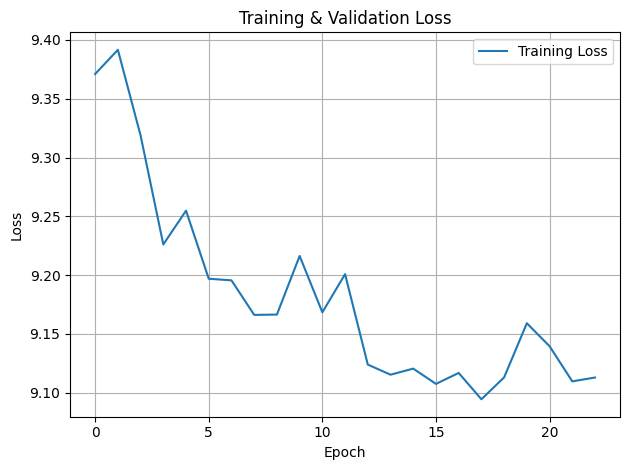

In [14]:
# plot the training / validation loss curves for SSL
train_loss = history_ssl.history.get('loss')
val_loss = history_ssl.history.get('val_loss')

plt.plot(train_loss, label='Training Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Classifier Training

In [15]:
# define the Classifier Models
def get_classifier(encoder, encoder_only=False, class_size=4, projector=None, coverage=0, dropout=0.1):
    if encoder_only:
        input_x = encoder.input
        x = encoder(input_x)
        x = tf.keras.layers.Concatenate()(x)
    else:
        input_x = encoder.input
        x = encoder(input_x, training=False)
        # x = tf.stack(x)
        # x = tf.transpose(x, (1, 0, 2))
        # modified for correctness in symbolic graph construction
        x = tf.keras.layers.Lambda(lambda x: tf.stack(x))(x)
        x = tf.keras.layers.Lambda(lambda x: tf.transpose(x, perm=[1, 0, 2]))(x)
        x = projector(x, training=False)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)  # Regularize with dropout
    classifier_model = tf.keras.layers.Dense(class_size, activation="softmax", name="classifier_last_dense")(x)
    # Combine encoder and extra layers
    c_model = tf.keras.Model(input_x, classifier_model)
    print(c_model.summary())
    return c_model

In [16]:
class CustomMetrics():
    # copied from unnir's post https://github.com/keras-team/keras/issues/5400

    def recall_m(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        true_positives = tf.keras.backend.sum(
            tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(
            tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        true_positives = tf.keras.backend.sum(
            tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(
            tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

    def f1_m(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        precision = CustomMetrics.precision_m(y_true, y_pred)
        recall = CustomMetrics.recall_m(y_true, y_pred)
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))



In [17]:
# split train into train and validation
trn_data = tf.data.Dataset.from_tensor_slices((X_train[:, :, [0]], X_train[:, :, [1]],
                                                   X_train[:, :, [2]]))
trn_data = tf.data.Dataset.zip((trn_data, tf.data.Dataset.from_tensor_slices(y_train)))
trn_data = trn_data.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_valid[:, :, [0]], X_valid[:, :, [1]],
                                                   X_valid[:, :, [2]]))
val_data = tf.data.Dataset.zip((val_data, tf.data.Dataset.from_tensor_slices(y_valid)))
val_data = val_data.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
tst_data = tf.data.Dataset.from_tensor_slices((X_test[:, :, [0]], X_test[:, :, [1]],
                                                   X_test[:, :, [2]]))
tst_data = tf.data.Dataset.zip((tst_data, tf.data.Dataset.from_tensor_slices(y_test)))
tst_data = tst_data.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
# train the classifier using labels
# freeze the aggregator / encoder in the beginning
encoder = ssl_model.encoder
aggregator = ssl_model.projector

print('Freeze Encoder/Aggregator for (max) 20 epochs!')
encoder.trainable = False
for l in encoder.layers:
    l.trainable = False
aggregator.trainable = False
for l in aggregator.layers:
    l.trainable = False

metrics = [tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy"),
                tf.keras.metrics.AUC(name="auc"), CustomMetrics.f1_m]
optimizer_cls = tf.keras.optimizers.Adam(lr_cls)
linear_cl = get_classifier(encoder, encoder_only=False, class_size=ds_info['class_size'], projector=aggregator)
linear_cl.compile(loss="categorical_crossentropy", metrics=metrics,
                        optimizer=optimizer_cls)
tensorboard_callback_cls = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=verbosity,
                                          restore_best_weights=True)
cbs = [tensorboard_callback_cls, es]
history_cls_phase1 = linear_cl.fit(trn_data,
                        validation_data=val_data,
                        batch_size=batch_size,
                        epochs=20,
                        callbacks=cbs)
epochs_phase1_ran = len(history_cls_phase1.history["loss"])  # could be < 20

print('='*50)
print(f'Unfreeze the Encoder/Aggregator for {epoch_cls-epochs_phase1_ran} epochs!')
encoder.trainable = True
for l in encoder.layers:
    l.trainable = True
aggregator.trainable = True
for l in aggregator.layers:
    l.trainable = True

print(linear_cl.summary())
history_cls_phase2 = linear_cl.fit(trn_data,
                        validation_data=val_data,
                        batch_size=batch_size,
                        epochs=epoch_cls,
                        callbacks=cbs,
                        initial_epoch=epochs_phase1_ran)    

#tsne_visualize(args.datapath, args.dataset, working_dir, base_encoder=base_model, exp_id=encoder_name, mode="fine_"+args.mode)
train_score = linear_cl.evaluate(trn_data, verbose=verbosity, return_dict=True)
print(" >>>>>> TRAIN SCORE : <<<<<<<<<\n", train_score)
test_score = linear_cl.evaluate(tst_data, verbose=verbosity, return_dict=True)
print(" >>>>>> TEST SCORE : <<<<<<<<<\n", test_score)

history_cls = {}
for key in history_cls_phase1.history:
    history_cls[key] = history_cls_phase1.history[key] + history_cls_phase2.history[key]

Freeze Encoder/Aggregator for (max) 20 epochs!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 96),      │    169,632 │ input_layer_1[0]… │
│ (Functional)        │ (None, 96),       │            │ input_layer_3[0]… │
│                     │ (None, 96)]       │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (3, None, 96)     │          0 │ functional[0][0], │
│                     │                   │            │ functional[0][1], │
│                     │                   │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 3, 96)     │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_head     │ (None, 32)        │     21,696 │ lambda_1[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      4,224 │ projection_head[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_last_de… │ (None, 4)         │        516 │ dropout_9[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 196,068 (765.89 KB)

 Trainable params: 4,740 (18.52 KB)

 Non-trainable params: 191,328 (747.38 KB)

None
Epoch 1/20


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - auc: 0.7410 - categorical_accuracy: 0.4886 - f1_m: 0.2397 - loss: 1.1755 - val_auc: 0.8603 - val_categorical_accuracy: 0.6390 - val_f1_m: 0.6098 - val_loss: 0.9002
Epoch 2/20
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.8762 - categorical_accuracy: 0.6860 - f1_m: 0.6472 - loss: 0.8509 - val_auc: 0.8819 - val_categorical_accuracy: 0.6777 - val_f1_m: 0.6546 - val_loss: 0.8287
Epoch 3/20
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.8918 - categorical_accuracy: 0.6969 - f1_m: 0.6779 - loss: 0.7968 - val_auc: 0.9007 - val_categorical_accuracy: 0.7040 - val_f1_m: 0.6829 - val_loss: 0.7613
Epoch 4/20
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.9019 - categorical_accuracy: 0.7119 - f1_m: 0.6958 - loss: 0.7589 - val_auc: 0.9076 - val_categorical_accuracy: 0.7115 - val_f1_m: 0.6916 - val_loss: 0.7338
Epoch 5/20
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9104 - categorical_accuracy: 0.7239 - f1_m: 0.7036 - loss: 0.7265 -

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 96),      │    169,632 │ input_layer_1[0]… │
│ (Functional)        │ (None, 96),       │            │ input_layer_3[0]… │
│                     │ (None, 96)]       │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (3, None, 96)     │          0 │ functional[0][0], │
│                     │                   │            │ functional[0][1], │
│                     │                   │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 3, 96)     │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_head     │ (None, 32)        │     21,696 │ lambda_1[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      4,224 │ projection_head[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_last_de… │ (None, 4)         │        516 │ dropout_9[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 205,550 (802.93 KB)

 Trainable params: 196,068 (765.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,482 (37.04 KB)

None
Epoch 21/50
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9570 - categorical_accuracy: 0.8044 - f1_m: 0.8008 - loss: 0.4986 - val_auc: 0.9613 - val_categorical_accuracy: 0.8191 - val_f1_m: 0.8142 - val_loss: 0.4721
Epoch 22/50
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9575 - categorical_accuracy: 0.8103 - f1_m: 0.8032 - loss: 0.4961 - val_auc: 0.9639 - val_categorical_accuracy: 0.8264 - val_f1_m: 0.8215 - val_loss: 0.4547
Epoch 23/50
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9591 - categorical_accuracy: 0.8132 - f1_m: 0.8071 - loss: 0.4864 - val_auc: 0.9625 - val_categorical_accuracy: 0.8188 - val_f1_m: 0.8122 - val_loss: 0.4649
Epoch 24/50
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9598 - categorical_accuracy: 0.8141 - f1_m: 0.8118 - loss: 0.4824 - val_auc: 0.9671 - val_categorical_accuracy: 0.8365 - val_f1_m: 0.8309 - val_loss: 0.4368
Epoch 25/50
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.9598 - categorical_accuracy: 0.8138 - f1_m: 0.8

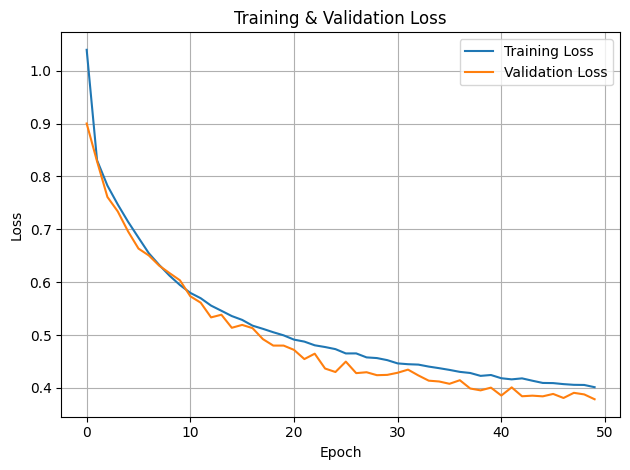

In [19]:
# plot the training / validation loss curves for Classifier
train_loss = history_cls['loss']
val_loss = history_cls['val_loss']  # Only present if you passed validation_data in fit()

plt.plot(train_loss, label='Training Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
print('Train data summary!')
probs = linear_cl.predict(trn_data)
y_pred = np.argmax(probs, axis=1)
y_true = np.argmax(y_train[:y_pred.size], axis=1)


# y_true should be your true labels, shape (num_samples,)
print(classification_report(y_true, y_pred, target_names=['B','S','A','M']))

Train data summary!


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 3s 785us/step
              precision    recall  f1-score   support

           B       0.90      0.93      0.91      7437
           S       0.90      0.87      0.89      4125
           A       0.76      0.63      0.69      2327
           M       0.84      0.88      0.86      4959

    accuracy                           0.87     18848
   macro avg       0.85      0.83      0.84     18848
weighted avg       0.87      0.87      0.87     18848



In [21]:
print('Validation data summary!')
probs = linear_cl.predict(val_data)
y_pred = np.argmax(probs, axis=1)
y_true = np.argmax(y_valid[:y_pred.size], axis=1)


# y_true should be your true labels, shape (num_samples,)
print(classification_report(y_true, y_pred, target_names=['B','S','A','M']))

Validation data summary!
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step
              precision    recall  f1-score   support

           B       0.89      0.93      0.91      2427
           S       0.91      0.85      0.88      1406
           A       0.73      0.61      0.67       793
           M       0.83      0.89      0.86      1654

    accuracy                           0.86      6280
   macro avg       0.84      0.82      0.83      6280
weighted avg       0.86      0.86      0.86      6280



In [22]:
print('Test data summary!')
probs = linear_cl.predict(tst_data)
y_pred = np.argmax(probs, axis=1)
y_true = np.argmax(y_test[:y_pred.size], axis=1)

# y_true should be your true labels, shape (num_samples,)
print(classification_report(y_true, y_pred, target_names=['B','S','A','M']))

Test data summary!
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step
              precision    recall  f1-score   support

           B       0.89      0.93      0.91      2455
           S       0.90      0.86      0.88      1435
           A       0.76      0.61      0.68       769
           M       0.83      0.89      0.86      1621

    accuracy                           0.86      6280
   macro avg       0.85      0.82      0.83      6280
weighted avg       0.86      0.86      0.86      6280

